# Reconstruction error effects

Using the cumulative effects of reconstruction errors for predicting web text as a metric for SAE quality.

In [1]:
import io
import json
from zstandard import ZstdDecompressor

import numpy as np
import matplotlib.pyplot as plt

import torch as t
import torch.nn.functional as F
from nnsight import LanguageModel

import sys
sys.path.append('..')
from dictionary_learning import AutoEncoder
from dictionary_circuits.attribution import patching_effect

In [2]:
DEVICE = "cuda:0"
DEBUGGING = True
D_MODEL = 512
D_SAE = 32768
DICT_ID = 5
DICT_PATH = "/share/projects/dictionary_circuits/autoencoders"
BATCH_SIZE = 32
CTX_LEN = 16

if DEBUGGING:
    tracer_kwargs = {'validate' : True, 'scan' : True}
else:
    tracer_kwargs = {'validate' : False, 'scan' : False}

In [3]:
# Load model
model = LanguageModel(
    "EleutherAI/pythia-70m-deduped",
    device_map = DEVICE,
    dispatch = True,
)

# Load submodules and dictionaries
# embed = model.gpt_neox.embed_in
attns = [layer.attention for layer in model.gpt_neox.layers]
mlps = [layer.mlp for layer in model.gpt_neox.layers]
resids = [layer for layer in model.gpt_neox.layers]
submodules = attns + mlps + resids# + [embed]

dictionaries = {}
submodule_to_name = {}
# ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
# ae.load_state_dict(t.load(f'{DICT_PATH}/pythia-70m-deduped/embed/{DICT_ID}_{D_SAE}/ae.pt'))
# dictionaries[embed] = ae
# submodule_to_name[embed] = 'embed'
for i in range(len(model.gpt_neox.layers)):
    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'{DICT_PATH}/pythia-70m-deduped/attn_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[attns[i]] = ae
    submodule_to_name[attns[i]] = f'attn{i}'

    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'{DICT_PATH}/pythia-70m-deduped/mlp_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[mlps[i]] = ae
    submodule_to_name[mlps[i]] = f'mlp{i}'

    ae = AutoEncoder(D_MODEL, D_SAE).to(DEVICE)
    ae.load_state_dict(t.load(f'{DICT_PATH}/pythia-70m-deduped/resid_out_layer{i}/{DICT_ID}_{D_SAE}/ae.pt'))
    dictionaries[resids[i]] = ae
    submodule_to_name[resids[i]] = f'resid{i}'

name_to_submodule = {v: k for k, v in submodule_to_name.items()}

# Run through a test input to figure out which hidden states are tuples
is_tuple = {}
with model.trace("_"):
    for submodule in submodules:
        is_tuple[submodule] = type(submodule.output.shape) == tuple

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [4]:
# Loading pile dataset

# Load data from the pile
data_path = '/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'
compressed_file = open(data_path, 'rb')
dctx = ZstdDecompressor()
reader = dctx.stream_reader(compressed_file)
text_stream = io.TextIOWrapper(reader, encoding='utf-8')

def generator():
    for line in text_stream:
        yield json.loads(line)['text']
data_generator = generator()

def tokenized_batch(generator, batch_size, ctx_len):
    try:
        texts = [next(generator) for _ in range(batch_size)]
    except StopIteration:
        raise StopIteration("End of data stream reached")
    
    return model.tokenizer(
        texts,
        return_tensors='pt',
        max_length=ctx_len,
        truncation=True,
        padding=True
        )

input_batch = tokenized_batch(data_generator, BATCH_SIZE, CTX_LEN)

# buffer = ActivationBuffer(
#     data,
#     model,
#     submodule,
#     submodule_input_dim=D_MODEL,
#     submodule_output_dim=D_SAE, # output dimension of the model component
#     n_ctxs=1e4, # you can set this higher or lower dependong on your available memory
#     ctx_len=128,
#     io='out', # buffer will return batches of tensors of dimension = submodule's output dimension
#     device='cuda:0' # doesn't have to be the same device that you train your autoencoder on
# ) # buffer will return batches of tensors of dimension = submodule's output dimension

In [5]:
def compute_effects(tokenized_batch):
    # Define input and answers
    contexts = tokenized_batch['input_ids'][:-1].to(DEVICE)
    answers = tokenized_batch['input_ids'][1:].to(DEVICE)

    def logprob_true(model):
        return F.log_softmax(model.embed_out.output, dim=-1).gather(-1, answers.unsqueeze(-1)).squeeze(-1)
        
    effects, deltas, grads, total_effect = patching_effect(
        clean=contexts,
        patch=None,
        model=model,
        submodules=submodules,
        dictionaries=dictionaries,
        metric_fn=logprob_true,
        method='ig',
    )

    return effects

In [6]:
batch_effects = compute_effects(input_batch)

cumulative_error_effects = 0
for submodule in submodules:
    cumulative_error_effects += batch_effects[submodule].resc.abs().sum()

print(f"Total error effects: {cumulative_error_effects}")
sum_eff_per_token = cumulative_error_effects / (BATCH_SIZE * CTX_LEN)
sum_eff_per_token

Total error effects: 6408.4892578125


tensor(12.5166, device='cuda:0')

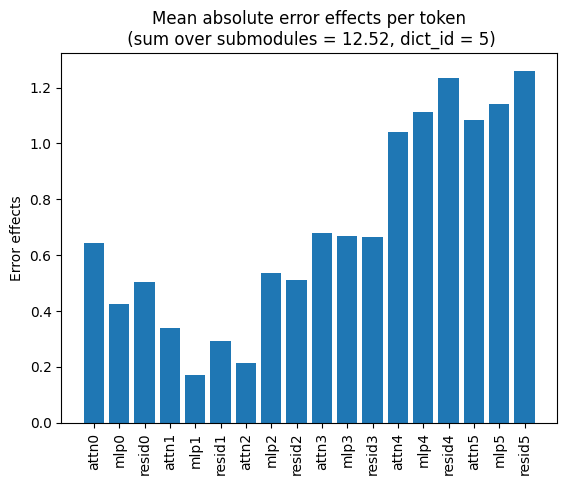

In [7]:
# Bar plot over the error effects
submodule_labels = [v for v in submodule_to_name.values()]
submodule_effects = [batch_effects[submodule].resc.abs().sum().item() for submodule in submodules]
# Normalize to error per token
n_tokens = BATCH_SIZE * CTX_LEN
submodule_effects = np.array(submodule_effects) / n_tokens

plt.bar(submodule_labels, submodule_effects)
plt.xticks(rotation=90)
plt.ylabel('Error effects')
plt.title(f'Mean absolute error effects per token\n (sum over submodules = {sum_eff_per_token:.2f}, dict_id = {DICT_ID})');